<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Градиентный-бустинг" data-toc-modified-id="Градиентный-бустинг-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Градиентный бустинг</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.



## Подготовка

In [1]:
import pandas as pd # библиотека Pandas
from sklearn.model_selection import train_test_split, TimeSeriesSplit # разделение на выборки
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor # Линейная регрессия
from sklearn.metrics import mean_squared_error # среднеквадратичная ошибка (MSE)
from statsmodels.tsa.seasonal import seasonal_decompose # декомпозиция на тренд и сезонность
from matplotlib import pyplot as plt # графики
from lightgbm import LGBMRegressor # модель бустинга
from sklearn.model_selection import GridSearchCV # поиск по сетке
import matplotlib.dates as mdates # форматирование дат на графиках
import numpy as np # NumPy
from sklearn.pipeline import Pipeline, FeatureUnion # pipe
from sklearn.preprocessing import StandardScaler # стандартизация

Считываем данные и сразу индексируем по датам.

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Сортируем данные и семплируем по одному часу с агрегирующей функцией суммы.

In [3]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

## Анализ

Проанализириуем данные за три дня, добавим скользящую среднюю.

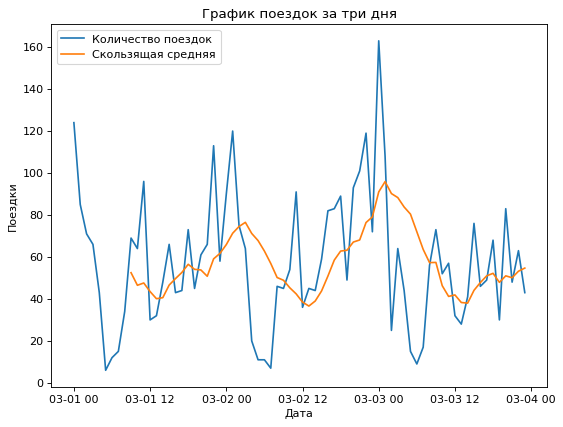

In [4]:
data['rolling_mean'] = data.rolling(10).mean()

fig = plt.figure(figsize=(8, 6), dpi=80)

ax = fig.add_subplot()
plt.title('График поездок за три дня')
plt.xlabel('Дата')
plt.ylabel('Поездки')
ax.plot(data['num_orders']['2018-03-01' : '2018-03-03'])
ax.plot(data['rolling_mean']['2018-03-01' : '2018-03-03'])
plt.legend(['Количество поездок', 'Скользящая средняя'])
plt.show()
data.drop(columns='rolling_mean', inplace=True)

По графику видно, что спрос на такси снижается примерно к 6 утра, растет до 12 часов дня, и далее периодично растет до полуночи. Попробуем ресемплировать по одному дню и посмотреть на график.

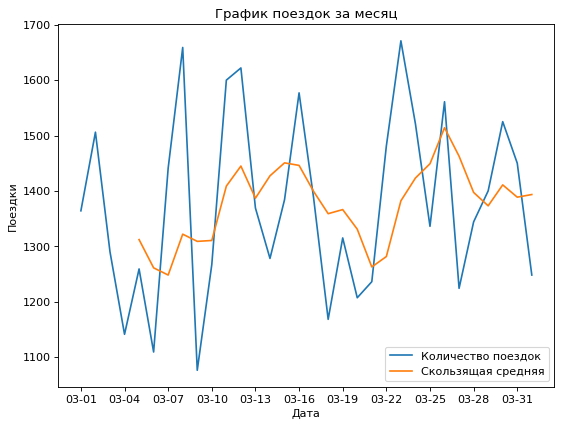

In [5]:
day_data = data.resample('1D').sum()
day_data['rolling_mean'] = day_data.rolling(5).mean()

fig = plt.figure(figsize=(8, 6), dpi=80)

ax = fig.add_subplot()
plt.title('График поездок за месяц')
plt.xlabel('Дата')
plt.ylabel('Поездки')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d')) 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3)) 
ax.plot(day_data['num_orders']['2018-03-01' : '2018-04-01'])
ax.plot(day_data['rolling_mean']['2018-03-01' : '2018-04-01'])
plt.legend(['Количество поездок', 'Скользящая средняя'])
plt.show()

Заметна некоторая периодичность, проверим спрос на такси по дням недели.

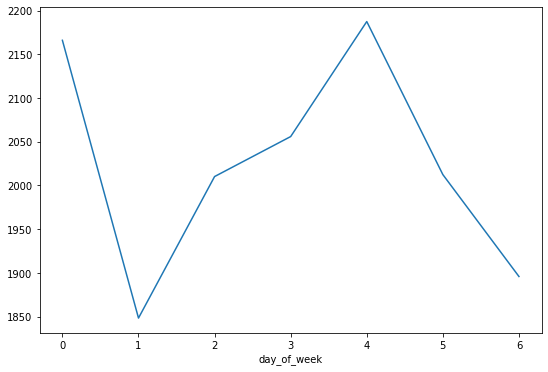

In [6]:
day_data['day_of_week'] = day_data.index.day_of_week
day_data.groupby('day_of_week')['num_orders'].mean().plot(figsize=(9, 6));

Самый высокий спрос на такси в понедельник и пятницу.

Построим графики тренда, сезонности и шума.

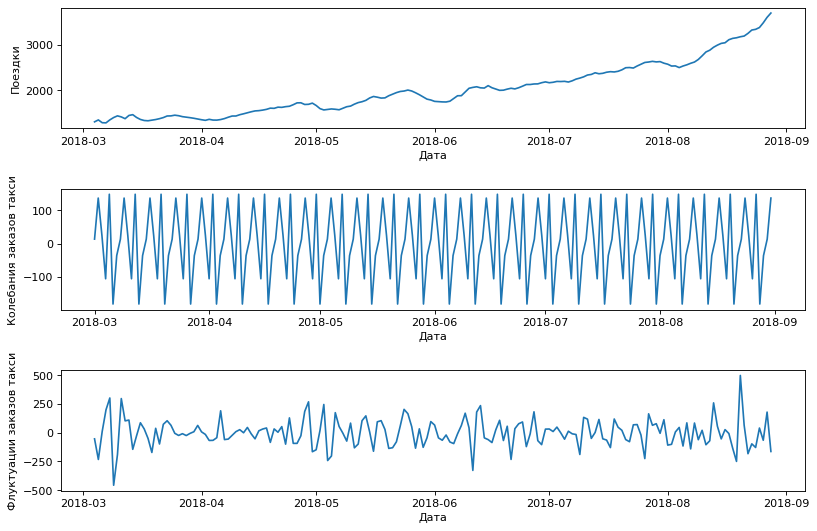

In [7]:
day_data = data.resample('1D').sum()
decomposed = seasonal_decompose(day_data)

fig = plt.figure(figsize=(12, 8), dpi=80)

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

plt.subplots_adjust(hspace=0.5)

ax1.plot(decomposed.trend)
ax2.plot(decomposed.seasonal)
ax3.plot(decomposed.resid)

ax1.set(xlabel='Дата', ylabel='Поездки')
ax2.set(xlabel='Дата', ylabel='Колебания заказов такси')
ax3.set(xlabel='Дата', ylabel='Флуктуации заказов такси')

plt.show()

В целом количество заказов такси уверенно растет, день от дня заказов может быть больше или меньше в пределах 100.

## Обучение

### Линейная регрессия

Обучим модель линейной регрессии с помощью кросс-валидации. Для этого потребуется создать признаки, по которым модель сможет делать предсказания. В качестве признаков будет выступать день, день недели, час, значение скользящей средней, а также предыдущее значение временного ряда. Все это мы добавим через функцию, в которой можно регулировать количество учитываемых предыдущих значений.

In [8]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [9]:
%%capture
make_features(data, 100, 100)

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

ts_cv = TimeSeriesSplit(n_splits = 3)
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('regr', Lasso())
])
param_grid = [
    {
        'regr': [Lasso(), Ridge()],
        'regr__alpha': np.logspace(-4, 1, 6),
    },
    {
        'regr': [SGDRegressor()],
        'regr__alpha': np.logspace(-5, 0, 6),
        'regr__max_iter': [500, 1000],
    },
]

linear_grid = GridSearchCV(pipe, param_grid=param_grid, cv=ts_cv, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
linear_grid.fit(features_train, target_train)


In [10]:
print('Лучший результат:', (-linear_grid.best_score_) ** 0.5)

Лучший результат: 24.64426301372342


Линейная регрессия показала результат 24 по метрике RMSE на обучающей выборке.

### Градиентный бустинг

Обучим модель LightGBM с использованием кроссвалидации.

In [11]:
gbm_model = LGBMRegressor()
grid_gbm_params = {
    'boosting_type' : ['gbdt'],
    'n_estimators' : [10, 20, 30],
    'max_depth' : [3, 5, 10],
    'verbose' : [-1],
    'random_state' : [75],
    'force_col_wise': [True]
}
grid_gbm_cv = GridSearchCV(estimator=gbm_model, param_grid=grid_gbm_params, cv=ts_cv, n_jobs=-1, scoring='neg_mean_squared_error')
grid_gbm_cv.fit(features_train, target_train)
print('Лучший результат:', (-grid_gbm_cv.best_score_) ** 0.5)

Лучший результат: 25.773397793195358


Модель бустинга получила результат 25 по метрике RMSE на обучающей выборке.

## Тестирование

In [12]:
linear_predict = linear_grid.best_estimator_.predict(features_test)
print("RMSE тестовой выборки линейной регрессии:", mean_squared_error(target_test, linear_predict) ** 0.5)
gbm_model_test = LGBMRegressor(**grid_gbm_cv.best_params_)
gbm_model_test.fit(features_train, target_train)
gbm_predict = gbm_model_test.predict(features_test)
print('Результат на тестовой выборке LightGBM:', mean_squared_error(target_test, gbm_predict) ** 0.5)

RMSE тестовой выборки линейной регрессии: 40.85447799274925
Результат на тестовой выборке LightGBM: 41.02755470291618


С небольшим отрывом линейная модель показала результат 40.8 по метрике RMSE.

## Вывод

В данной работе требовалось обучить модель, которая могла бы предсказывать спрос на такси в зависимости от времени суток.

Предложенные данные о поездках были проиндексированы по датам, ресемплированы по одному часу и отсортированы. Информация была проиллюстрирована графиками, по которым выяснилось, что наибольший спрос на такси идет с утра до полудня и с вечера до полуночи.

Чтобы обучить модели были добавлены признаки, которые содержат в себе информацию о дне недели, дне месяца, часе и т.д.

Всего было обучено две модели: линейной регрессии и градиентного стохастического бустинга LightGMB, которые показали примерно одинаковый результат на тестовых данных по метрике RMSE равный 40.